# Eurovision Analysis (Part I)

This notebook explores voting patterns in the Eurovision Song Contest finals from 2016 to 2021. The focus of the analysis is on comparing the differences between the musical tastes of televoters and the musical jury in each country.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import plotly.express as px
import re
import seaborn as sns
from sklearn import preprocessing, decomposition, cluster, manifold
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#%pip install "notebook>=5.3" "ipywidgets>=7.5"

In [3]:
pd.set_option('display.max_rows', None) # increase number of rows displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

## 1. Data Wrangling

In [4]:
def read_file(file_name):
    """Reads csv file and returns a pandas dataframe"""
    df = pd.read_csv(file_name)
    return df

In [5]:
data = read_file('../data/eurovision_1957-2021.csv')
data.head()

Unnamed: 0         Edition  Year                 Points type    From  \
0       0.000  rotterdam-2021  2021  Points given by televoters  cyprus   
1       1.000  rotterdam-2021  2021  Points given by televoters  cyprus   
2       2.000  rotterdam-2021  2021  Points given by televoters  cyprus   
3       3.000  rotterdam-2021  2021  Points given by televoters  cyprus   
4       4.000  rotterdam-2021  2021  Points given by televoters  cyprus   

         To  Points  
0    greece      12  
1     italy      10  
2    france       8  
3  bulgaria       7  
4   ukraine       6

In [6]:
def remove_columns(df):
    """Drop unnecessary columns of data"""
    df_clean = df.drop(columns=['Unnamed: 0','Edition'], axis=1) # remove redundant column
    return df_clean

In [7]:
data = remove_columns(data)    
data.head()

Year                 Points type    From        To  Points
0  2021  Points given by televoters  cyprus    greece      12
1  2021  Points given by televoters  cyprus     italy      10
2  2021  Points given by televoters  cyprus    france       8
3  2021  Points given by televoters  cyprus  bulgaria       7
4  2021  Points given by televoters  cyprus   ukraine       6

In [8]:
def filter_years(df, year):
    """Retains only the data after the specified year"""
    df_filtered = df[df.Year >= year]
    return df_filtered

In [9]:
data = filter_years(data, 2016)
data.Year.unique()

array([2021, 2019, 2018, 2017, 2016])

In [10]:
def inspect_data(df):
    """Check for missing values, data ranges, data types and unique values
    for countries
    """
    print("Missing Values: \n", df.isnull().sum(), "\n")
    print("Summary Statistics: \n", df.describe(), "\n")
    print("Data Types: \n", df.dtypes)
    print("Unique Values: 'From' \n", df['From'].unique(), "\n")
    print("Unique Values: 'To' \n", df['To'].unique(), "\n")

In [11]:
inspect_data(data)

Missing Values: 
 Year           0
Points type    0
From           0
To             0
Points         0
dtype: int64 

Summary Statistics: 
           Year   Points
count 2600.000 2600.000
mean  2018.200    5.800
std      1.721    3.341
min   2016.000    1.000
25%   2017.000    3.000
50%   2018.000    5.500
75%   2019.000    8.000
max   2021.000   12.000 

Data Types: 
 Year            int64
Points type    object
From           object
To             object
Points          int64
dtype: object
Unique Values: 'From' 
 ['cyprus' 'albania' 'israel' 'belgium' 'russia' 'malta' 'portugal'
 'serbia' 'united-kingdom' 'greece' 'switzerland' 'iceland' 'spain'
 'moldova' 'germany' 'finland' 'bulgaria' 'lithuania' 'ukraine' 'france'
 'azerbaijan' 'norway' 'the-netherlands' 'italy' 'sweden' 'san-marino'
 'czech-republic' 'denmark' 'slovenia' 'estonia' 'belarus' 'australia'
 'austria' 'hungary' 'ireland' 'poland' 'armenia' 'croatia' 'romania'
 'latvia' 'georgia' 'north-macedonia'] 

Unique Values: 'To'

In [12]:
def clean_names(df):
    """Remove hidden blank spaces and dashes from names in dataframe"""
    df['From'] = df['From'].apply(lambda row: re.sub('-', ' ', row.strip()))
    df['To'] = df['To'].apply(lambda row: re.sub('-', ' ', row.strip()))
    df['Points type'] = df['Points type'].apply(lambda row: row.strip())
    return df

In [13]:
data = clean_names(data)

In [14]:
def check_sum(data):
    """Check the points have been recorded correctly per year and country"""
    df = data[['Year','From','Points']].groupby(['Year']).sum()
    return df

In [15]:
check_sum(data)

Points
Year        
2016    3016
2017    3016
2018    3016
2019    3016
2021    3016

In [16]:
def create_additional_columns(df):
    """Create identifier columns for each voter type and country combination
    and for voter type, and an adjusted points column
    """
    df.insert(1, 'voter', df.apply(lambda row: label_voter_type(row), axis=1))
    df.insert(1, 'voter_country', df['voter'] + '_' + df['From'])
    df['adjusted_points'] = df.apply(lambda row: adjusted_points(row), axis=1)
    return df

def label_voter_type(row):
    """Returns the voter type"""
    if re.search(r'televoter', row['Points type']):
        return 'televoter'
    elif re.search(r'jury', row['Points type']):
        return 'jury'
    
def adjusted_points(row):
    """Adjusts the 10 and 12 points to 9 and 10 (so there's even 
    spacing between points)
    """
    if row['Points'] == 12:
        return 10
    elif row['Points'] == 10:
        return 9
    else:
        return row['Points']

In [17]:
data = create_additional_columns(data)
data.head(20)

Year     voter_country      voter                 Points type    From  \
0   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
1   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
2   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
3   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
4   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
5   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
6   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
7   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
8   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
9   2021  televoter_cyprus  televoter  Points given by televoters  cyprus   
10  2021       jury_cyprus       jury    Points given by the jury  cyprus   
11  2021       jury_cyprus       jury    Points given by the jury  cyprus   
12  2021       jury_cyprus       jury    Points given by the jury  cyprus   
13  2021       jury_cyprus       jury    Points given by the jury  cyprus   
14  2021       jury_cyprus       jury    Points given by the jury  cyprus   
15  2021       jury_cyprus       jury    Points given by the jury  cyprus   
16  2021       jury_cyprus       jury    Points given by the jury  cyprus   
17  2021       jury_cyprus       jury    Points given by the jury  cyprus   
18  2021       jury_cyprus       jury    Points given by the jury  cyprus   
19  2021       jury_cyprus       jury    Points given by the jury  cyprus   

             To  Points  adjusted_points  
0        greece      12               10  
1         italy      10                9  
2        france       8                8  
3      bulgaria       7                7  
4       ukraine       6                6  
5     lithuania       5                5  
6       finland       4                4  
7        russia       3                3  
8        israel       2                2  
9         malta       1                1  
10       greece      12               10  
11        malta      10                9  
12        italy       8                8  
13       france       7                7  
14       russia       6                6  
15     bulgaria       5                5  
16      belgium       4                4  
17      finland       3                3  
18  switzerland       2                2  
19     portugal       1                1

In [18]:
data = data.drop(columns=['Points type'], axis=1)
data.head()

Year     voter_country      voter    From        To  Points  \
0  2021  televoter_cyprus  televoter  cyprus    greece      12   
1  2021  televoter_cyprus  televoter  cyprus     italy      10   
2  2021  televoter_cyprus  televoter  cyprus    france       8   
3  2021  televoter_cyprus  televoter  cyprus  bulgaria       7   
4  2021  televoter_cyprus  televoter  cyprus   ukraine       6   

   adjusted_points  
0               10  
1                9  
2                8  
3                7  
4                6

## 2. EDA - Points Difference

We begin by comparing the overall points difference between televoters and the jury of each country, for each year

In [19]:
def plot_points_map(df, year):
    """Plot points distribution for televoters and jury"""
    # create matrix of votes from/to by televoter
    televoter_df = df[(df.Year==year) & (df.voter=='televoter')]
    televoter_df_pivot = (televoter_df.pivot_table(
        index='To', columns='From', values='Points', fill_value=0, aggfunc='sum'))
    # identify missing values and fill these in
    missing_countries = list(set(televoter_df.From) - set(televoter_df.To))
    for country in missing_countries:
        televoter_df_pivot.loc[country] = [0] * len(televoter_df_pivot.columns)
    televoter_df_pivot = televoter_df_pivot.sort_index()
    # create matrix of votes from/to by jury
    jury_df = df[(df.Year==year) & (df.voter=='jury')]
    jury_df_pivot = (jury_df.pivot_table(
        index='To', columns='From', values='Points', fill_value=0, aggfunc='sum')) 
    # identify missing values and fill these in
    missing_countries = list(set(jury_df.From) - set(jury_df.To))
    for country in missing_countries:
        jury_df_pivot.loc[country] = [0] * len(jury_df_pivot.columns)
    jury_df_pivot = jury_df_pivot.sort_index()    
    # plot chart
    fig, (ax1, ax2) = plt.subplots(1,2)      
    fig.set_size_inches(16,6)    
    sns.heatmap(televoter_df_pivot, xticklabels=True, yticklabels=True, cmap="Reds", ax=ax1)
    sns.heatmap(jury_df_pivot, xticklabels=True, yticklabels=True, cmap="Blues", ax=ax2)   
    ax1.set(title='Televoter Votes for {}'.format(year), xlabel="Points From", ylabel="Points To")
    ax2.set(title='Jury Votes for {}'.format(year), xlabel="Points From", ylabel="Points To")
    plt.show()
    
    

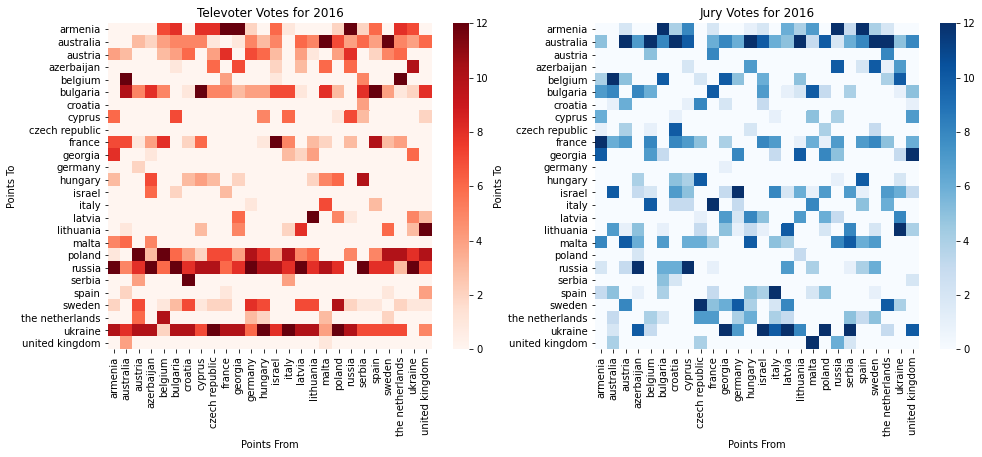

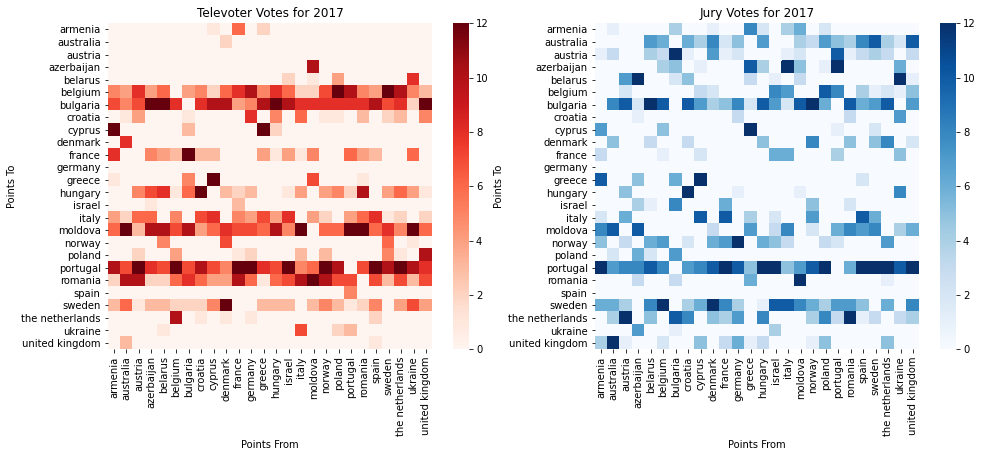

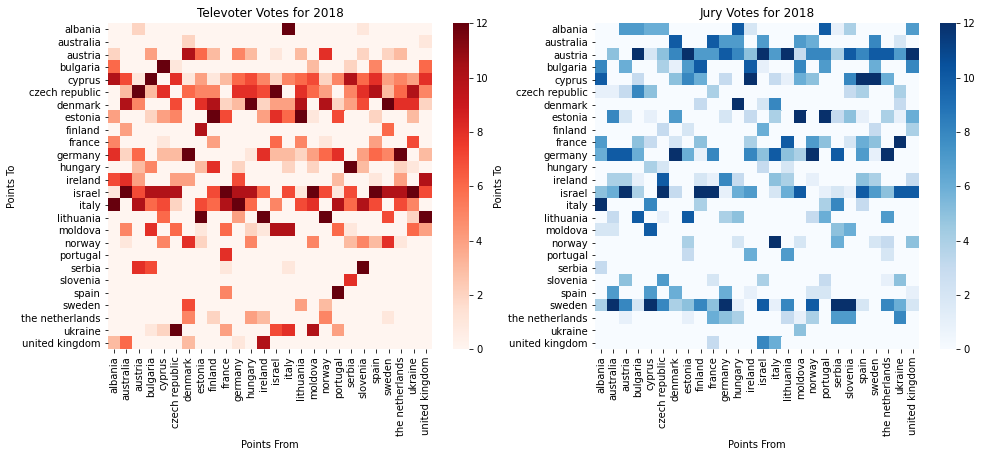

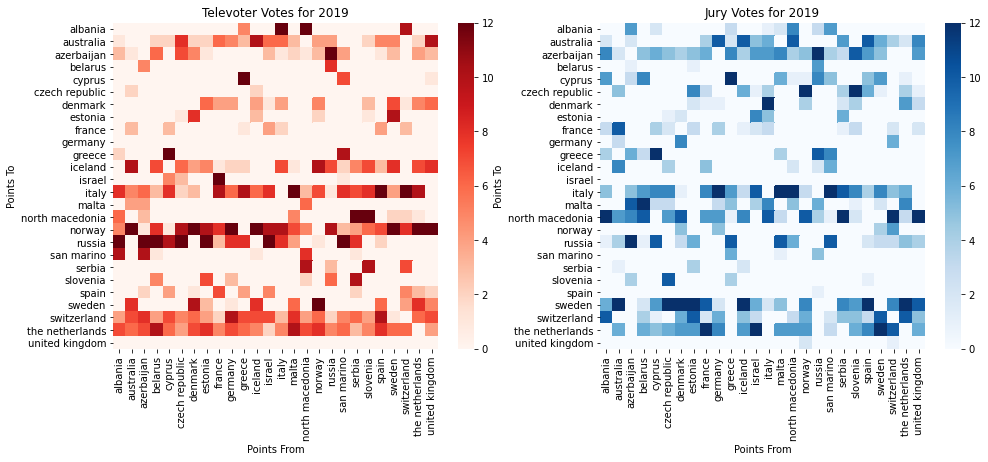

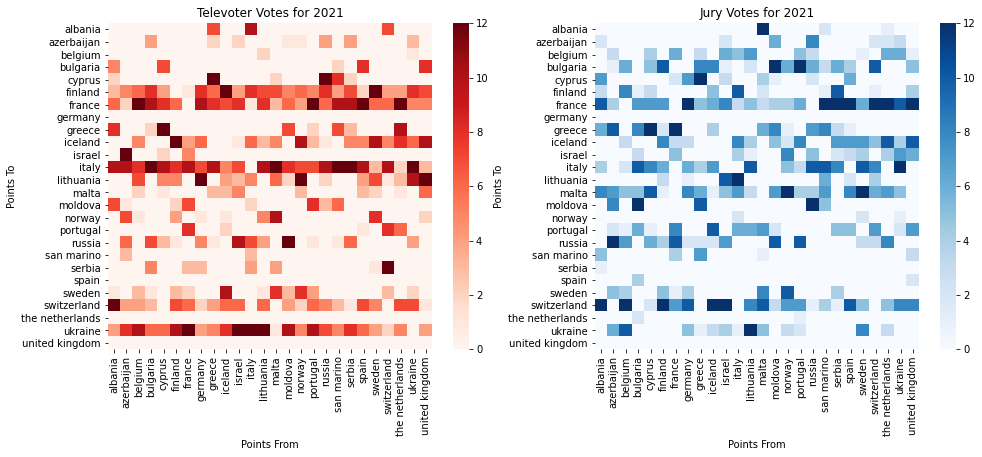

In [20]:
years = [2016, 2017, 2018, 2019, 2021]
for year in years:
    plot_points_map(data, year)

In [21]:
def points_diff(df, year):
    """Calculate the difference in points between televoter and jury by
    country
    """
    df_filtered_by_year = df[df.Year==year]
    df_pivot = (df_filtered_by_year.pivot_table(
        index='To', columns=['From','voter'], values='Points', 
        aggfunc='sum', fill_value=0))
    # calculate difference in values between the voter types
    df_diff = (df_pivot.loc[:, pd.IndexSlice[:, 'televoter']]
        - df_pivot.loc[:,pd.IndexSlice[:,'jury']].values)
    df_diff = df_diff.droplevel('voter', axis=1)
    # get missing list of countries with zero points
    missing_countries = list(set(df_filtered_by_year.From.unique())
        - set(df_filtered_by_year.To.unique()))
    # add missing countries to data frame
    for country in missing_countries:
        df_diff.loc[country] = [0]*len(df_diff.columns)   
    df_diff = df_diff.sort_index()
    df_diff_sum = pd.DataFrame(df_diff.sum(axis=1), columns=['Diff']).sort_values(by='Diff', ascending=False).reset_index()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15,6)
    sns.barplot(y='To',x='Diff', palette="vlag_r", data=df_diff_sum, ax=ax1)
    sns.heatmap(
        df_diff, xticklabels=df_diff.columns, yticklabels=df_diff.columns, 
        vmin=-12, vmax=12, cmap="vlag", ax=ax2)
    ax1.set(title="Aggregate Points Difference for {}".format(year), xlabel="Points Difference", ylabel="Points To", xlim=(-180,180))
    ax2.set(title="Country Level Points Difference for {}".format(year), xlabel="Points From", ylabel="Points To")
    plt.subplots_adjust(wspace=0.4)
    plt.show()

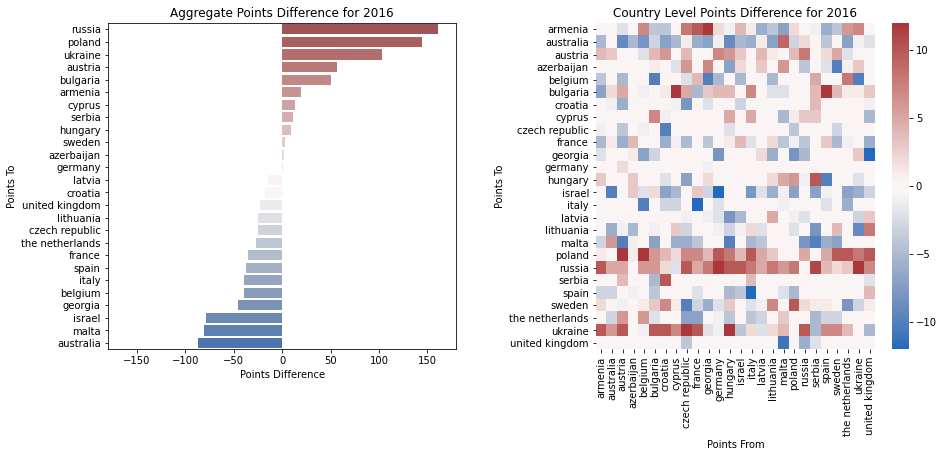

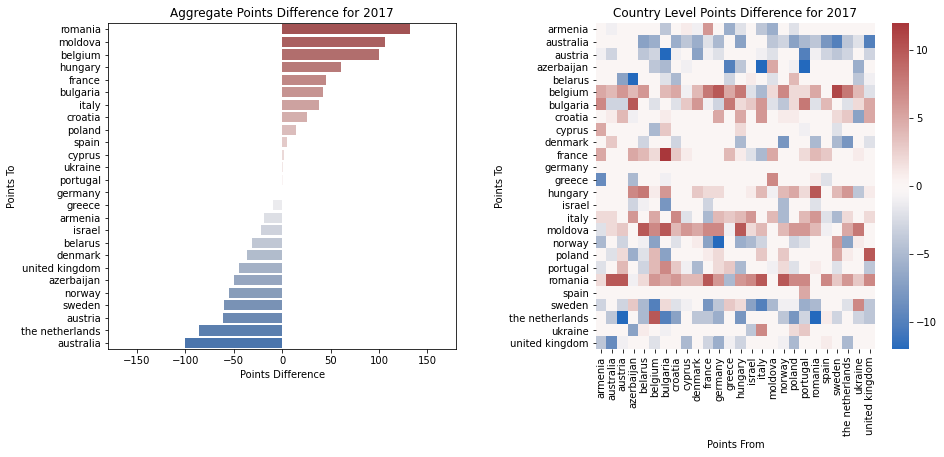

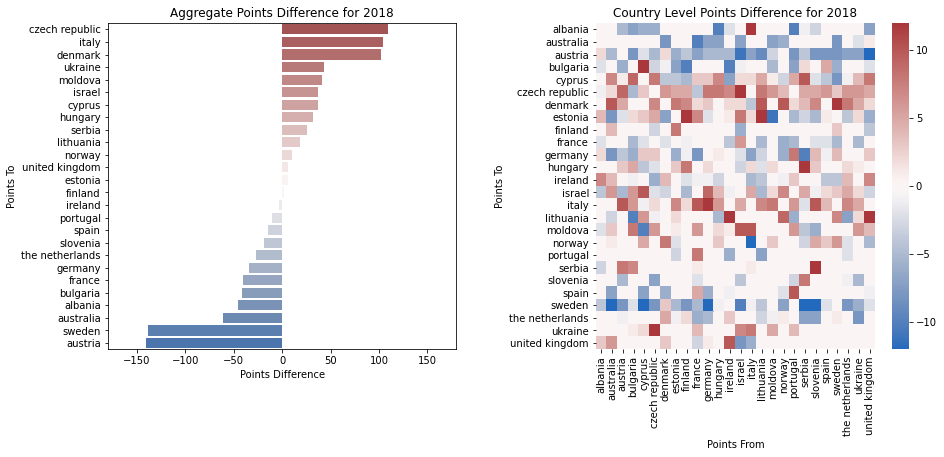

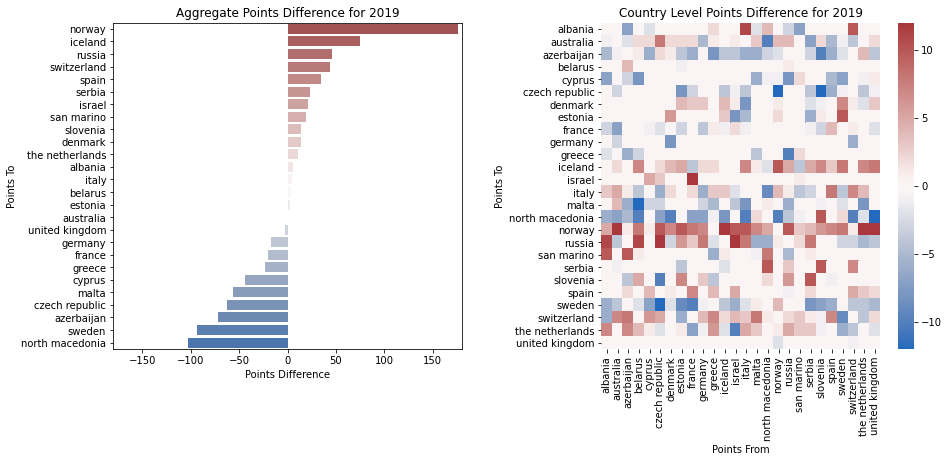

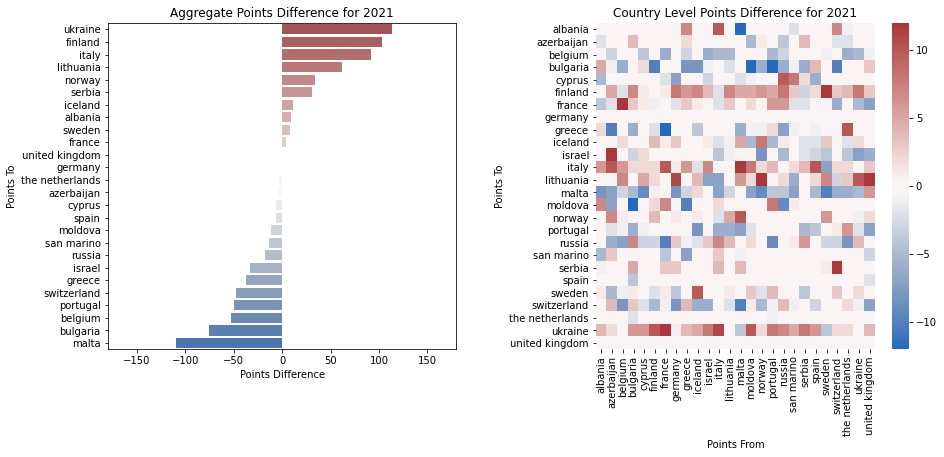

In [22]:
years = [2016, 2017, 2018, 2019, 2021]
for year in years:
    points_diff(data, year)

##### Comments
- In each year, there are songs with a strong difference in opinion between the jury and televoters across countries (represented by horizontal rows with a darker colour)
- From 2017 to 2019, there was a 'halo' effect for Sweden, with the jury votes for Sweden generally higher than the televoter votes across multiple countries
- The strongest differences in jury/televoter opinion were observed for Russia's entry in 2016 and Norway's entry in 2019
- When Australia joined the Eurovision Song Contest officially in 2016, the jury scores were generally higher than the televoters and this pattern continued to 2018. However, there was a shift in 2019 with 13 countries having a higher televoter scores than the general public  
- There are some interesting details to extract from the heatmap, such as the jury of the Czech Republic favouring Sweden more than the Czech public in the past 3 contests they have been in. 

## 3. Cosine SImilarity

This analysis explores similarities in voting patterns between televoters and juries. 

We model the voting preferences of televoters and the juries as vectors. Cosine distances are computed to compare similarities, providing a score between 0 and 1 (scores closer to 1 indicate a higher similarity, as the angle between the vectors is closer to 0). To ensure the cosine distances are not skewed by higher points awarded to the top 2 countries, adjusted points have been used (so 10 points is scaled down to 9, and 12 points is scaled down to 10).

In [23]:
def create_df_wide_by_year(df, year):
    """Adds the missing combinations of countries from/to and fills value
    with a zero"""
    df_filtered_by_year = df[df.Year==year].drop(columns=['Points'], axis=1)
    df_wide = (df_filtered_by_year.pivot_table(
        index=['voter_country','voter','From'],
        columns=['To'],
        values='adjusted_points',
        aggfunc='sum',
        fill_value=0))
    # get missing list of countries with zero points
    missing_countries = list(set(df_filtered_by_year.From.unique())
        - set(df_filtered_by_year.To.unique()))
    # add missing countries to data frame
    for country in missing_countries:
        df_wide[country] = 0    
    # re-sort the columns in dataframe
    df_wide = df_wide[df_wide.columns.sort_values()]
    np_matrix = df_wide.to_numpy()
    # get the names of the countries
    country_labels = df_wide.columns    
    # get the labels for voter_country combination
    voter_country_labels = df_wide.index.get_level_values(0)
    return df_wide, np_matrix, country_labels, voter_country_labels

In [24]:
def calc_cosine_similarity(np_matrix, voter_country_labels, country_labels):
    """Calculate cosine similarity matrix on voter preferences"""
    cosine_sim_matrix = cosine_similarity(np_matrix)
    cosine_sim_matrix_len = cosine_sim_matrix.shape[0]
    i1 = int(cosine_sim_matrix_len/2) # index to only select first n/2 entries
    i2 = cosine_sim_matrix_len # index to select up to the end of the matrix
    # similarity scores for all voter-country combinations
    df_cosine_sim_all = pd.DataFrame(cosine_sim_matrix,
        columns=voter_country_labels,
        index=voter_country_labels)
    # similarity scores for televoters vs jury
    df_cosine_sim_tvj = df_cosine_sim_all.iloc[i1:i2,0:i1]
    # similarity scores for voters vs jury (per country)
    list_diagonals_tvj = ([df_cosine_sim_tvj.iat[n, n]
        for n in range(len(df_cosine_sim_tvj))])
    df_tvj_diagonals = pd.DataFrame(
        list(zip(list(country_labels),
        list_diagonals_tvj)), columns=['Country','Similarity'])
    return df_cosine_sim_all, df_cosine_sim_tvj, df_tvj_diagonals

In [25]:
def plot_similarity(df_cosine_sim_tvj, df_tvj_diagonals, year):
    """Plot heatmap of similarity matrix"""
    
    col_ref = [re.sub('jury_','',col) for col in list(df_cosine_sim_tvj.columns)]
    index_ref = [re.sub('televoter_','',ind) for ind in list(df_cosine_sim_tvj.index)]        
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16,6)
    sns.heatmap(
        df_cosine_sim_tvj, 
        xticklabels=col_ref, yticklabels=index_ref, 
        vmin=0, vmax=1, ax=ax1)
    ax1.set(title="Similarity Matrix for {}".format(year), 
        xlabel="Jury Vote", ylabel="Televoter Vote")
    country_order = df_tvj_diagonals.sort_values(by="Similarity", ascending=False)['Country']
    colour_order = df_tvj_diagonals.sort_values(by="Similarity", ascending=False)['Similarity']
    sns.barplot(y="Country", x="Similarity", data=df_tvj_diagonals,
        order=country_order, palette=mpl.cm.magma(colour_order), ax=ax2)
    ax2.set(title="Similarity Scores between Televoters and Jury by Country for {}".format(year), 
        xlabel="Similarity Score", xlim=(0,1))
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [26]:
def print_top_bottom_n_similarity(df_wide, df_tvj_diagonals, n=3):
    """Displays the voting patterns for the top/bottom n countries"""
    
    tbl = df_tvj_diagonals.sort_values(by='Similarity', ascending=False)
    top_n_countries = tbl.head(n)['Country']
    bottom_n_countries = tbl.tail(n)['Country']
    
    print('Top {} Countries with Similar Scores'.format(n))
    print(list(top_n_countries))    
    for country in top_n_countries:
        df = df_wide.loc[pd.IndexSlice[:,:,country],:]
        df = df.loc[:,(df!=0).any(axis=0)]
        print(df.T)
    
    print('Bottom {} Countries with Similar Scores'.format(n))
    print(list(bottom_n_countries))
    for country in bottom_n_countries:
        df = df_wide.loc[pd.IndexSlice[:,:,country],:]
        df = df.loc[:,(df!=0).any(axis=0)]
        print(df.T)

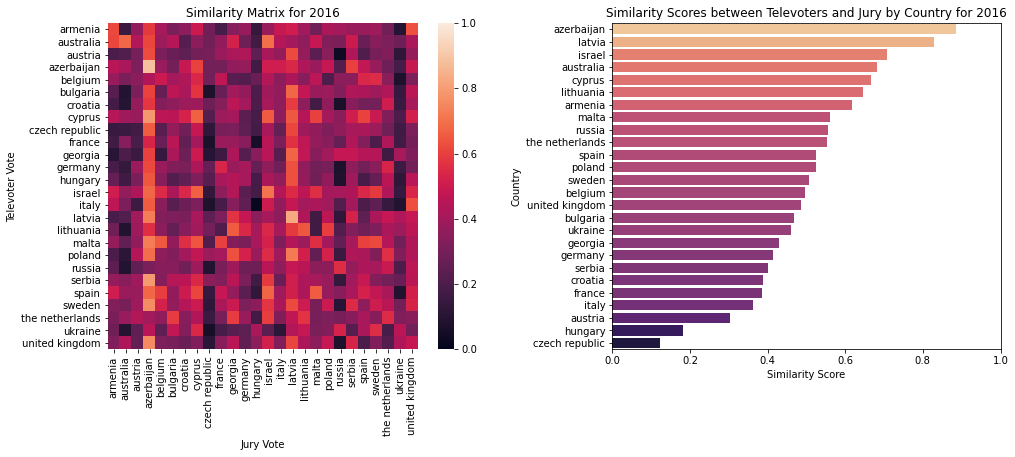

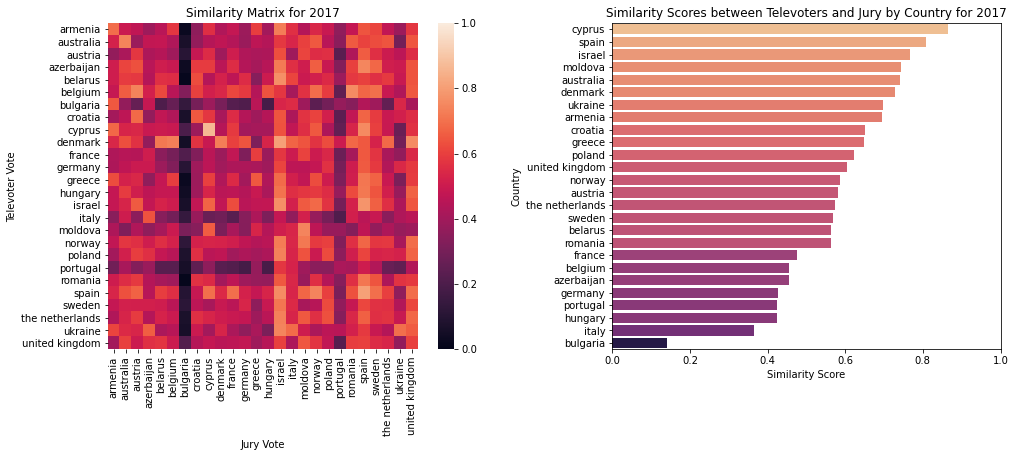

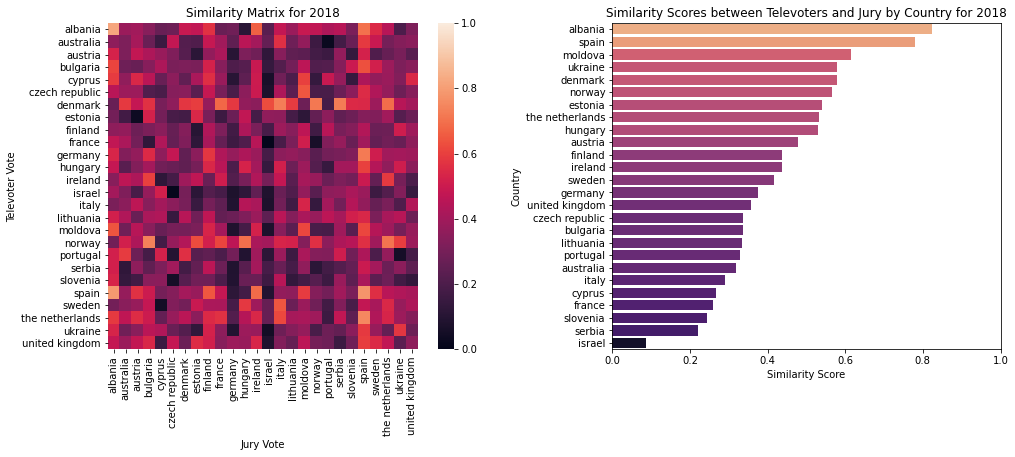

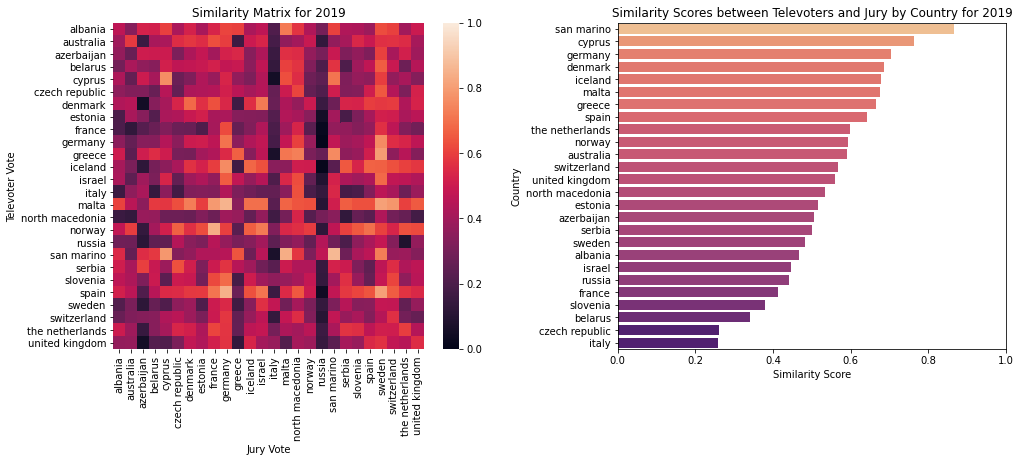

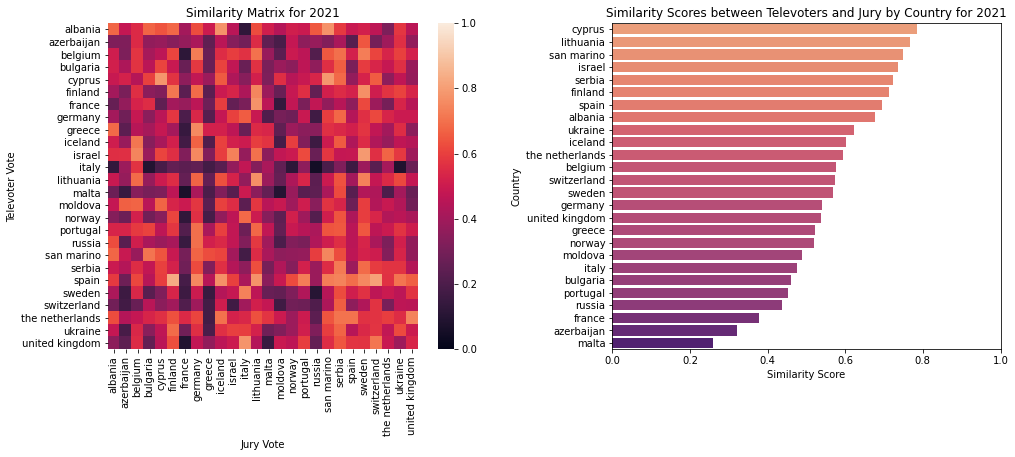

In [27]:
years = [2016, 2017, 2018, 2019, 2021]
df_cosinesim_by_year_list = []

for year in years:
    df_wide, np_matrix, country_labels, voter_country_labels = create_df_wide_by_year(data, year)
    df_cosine_sim_all, df_cosine_sim_tvj, df_tvj_diagonals = calc_cosine_similarity(np_matrix, voter_country_labels, country_labels)
    plot_similarity(df_cosine_sim_tvj, df_tvj_diagonals, year)
#    print_top_bottom_n_similarity(df_wide, df_tvj_diagonals, n=3)    
    # collect the similarity scores by country by year for temporal analysis
    df_tvj_diagonals['Year'] = year
    df_cosinesim_by_year_list.append(df_tvj_diagonals)

##### Comments
- When the cosine similarities are compared, it can be observed that the jury and televoters of Cyprus have similar voting patterns in most years. 
- In contrast, the jury and televoters of Italy generally have the least similar voting patterns.
- In 2017, the Bulgarian jury had the most different voting patterns compared with televoters - their top points were awarded to Austria and no points were awarded to Portugal

In [28]:
# examine some of the biggest differences
df_wide, *_ = create_df_wide_by_year(data, 2017)
jury = df_wide.loc[pd.IndexSlice['jury_bulgaria',:,:],:]
televoter = df_wide.loc[pd.IndexSlice[:,'televoter',:],:]
combined = pd.concat([jury, televoter], axis=0)
combined.loc[:,(combined!=0).any(axis=0)]

To                                                   armenia  australia  \
voter_country             voter     From                                  
jury_bulgaria             jury      bulgaria               4          0   
televoter_armenia         televoter armenia                0          0   
televoter_australia       televoter australia              0          0   
televoter_austria         televoter austria                0          0   
televoter_azerbaijan      televoter azerbaijan             0          0   
televoter_belarus         televoter belarus                0          0   
televoter_belgium         televoter belgium                0          0   
televoter_bulgaria        televoter bulgaria               0          0   
televoter_croatia         televoter croatia                0          0   
televoter_cyprus          televoter cyprus                 1          0   
televoter_denmark         televoter denmark                0          2   
televoter_france          televoter france                 6          0   
televoter_germany         televoter germany                0          0   
televoter_greece          televoter greece                 2          0   
televoter_hungary         televoter hungary                0          0   
televoter_israel          televoter israel                 0          0   
televoter_italy           televoter italy                  0          0   
televoter_moldova         televoter moldova                0          0   
televoter_norway          televoter norway                 0          0   
televoter_poland          televoter poland                 0          0   
televoter_portugal        televoter portugal               0          0   
televoter_romania         televoter romania                0          0   
televoter_spain           televoter spain                  0          0   
televoter_sweden          televoter sweden                 0          0   
televoter_the netherlands televoter the netherlands        0          0   
televoter_ukraine         televoter ukraine                0          0   
televoter_united kingdom  televoter united kingdom         0          0   

To                                                   austria  azerbaijan  \
voter_country             voter     From                                   
jury_bulgaria             jury      bulgaria              10           5   
televoter_armenia         televoter armenia                0           0   
televoter_australia       televoter australia              0           0   
televoter_austria         televoter austria                0           0   
televoter_azerbaijan      televoter azerbaijan             0           0   
televoter_belarus         televoter belarus                0           0   
televoter_belgium         televoter belgium                0           0   
televoter_bulgaria        televoter bulgaria               0           0   
televoter_croatia         televoter croatia                0           0   
televoter_cyprus          televoter cyprus                 0           0   
televoter_denmark         televoter denmark                0           0   
televoter_france          televoter france                 0           0   
televoter_germany         televoter germany                0           0   
televoter_greece          televoter greece                 0           0   
televoter_hungary         televoter hungary                0           0   
televoter_israel          televoter israel                 0           0   
televoter_italy           televoter italy                  0           0   
televoter_moldova         televoter moldova                0           9   
televoter_norway          televoter norway                 0           0   
televoter_poland          televoter poland                 0           0   
televoter_portugal        televoter portugal               0           0   
televoter_romania         televoter romania                0           0   


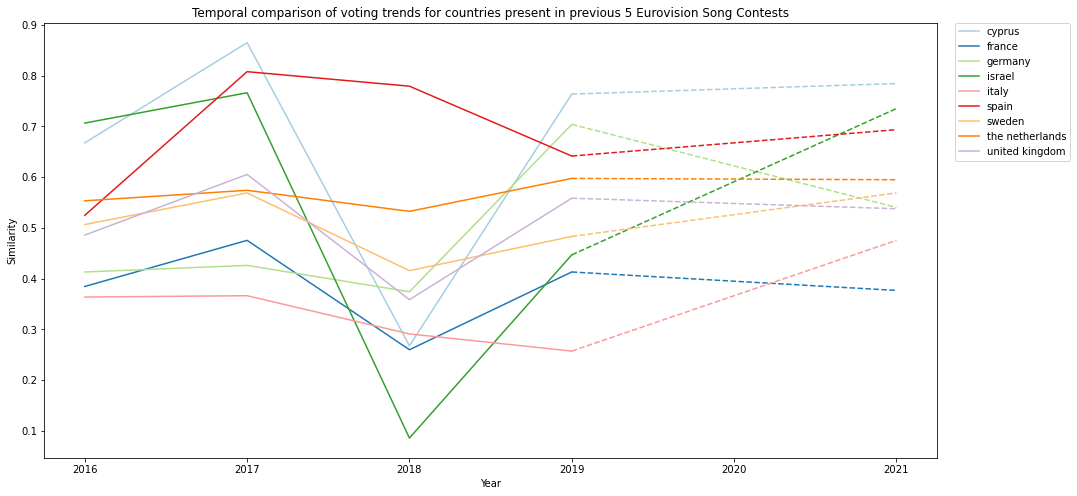

In [29]:
# temporal analysis of results
df_cosinesim_combined = pd.concat(df_cosinesim_by_year_list, ignore_index=True)
country_counts = df_cosinesim_combined['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']
country_counts_5 = list(country_counts[country_counts.Count == 5].Country)
df_cosinesim_combined_subset = df_cosinesim_combined[df_cosinesim_combined.Country.isin(country_counts_5)]

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(16,8)
sns.lineplot(
    data=df_cosinesim_combined_subset[df_cosinesim_combined_subset.Year<=2019], 
    x="Year", y="Similarity", 
    hue="Country", palette="Paired", ax=ax1)
sns.lineplot(
    data=df_cosinesim_combined_subset[df_cosinesim_combined_subset.Year>=2019], 
    x="Year", y="Similarity", linestyle="dashed",
    hue="Country", palette="Paired", ax=ax1)

handles, labels = ax1.get_legend_handles_labels()
num_legend = int(len(labels)/2)
ax1.legend(handles[:num_legend], labels[:num_legend], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels=country_counts_5.sort())
ax1.set_title("Temporal comparison of voting trends for countries present in previous 5 Eurovision Song Contests")
plt.show()

##### Comments:
Generally, the similarity scores are high for Cyprus compared to other countries. 

We observe an interesting phenomena where the similarity scores decreased in 2018 across countries, some more than others. In 2018, there were many differences in voting between the televoters and jury, (this can also be observed in the points difference heatmap). 

## 4. Visualising the Embedding Space

This section explores whether any insights can be gained from visually comparing the voting patterns in an embedding space. For this, we apply two common techniques - PCA and TSNE.

PCA is a linear method of dimensionality reduction, which seeks to maximise the variance in the data. 
When we visualise data with PCA, it's worth noting that a 2D projection may not be completely accurate, as we're operating in multidimensional space (a 3D projection will provide a better view of the differences between data points). With PCA it is generally best practice to normalize the data beforehand (if the features have not been measured to the same scale). Technically, the points are all measured to the same scale, but as the scores for some countries may be more limited in range, we'll normalize the data to bring everything to a common scale. At a minimum, the explained variance of PCA should be at least 70% to be a good representation of the variability in the data. For smaller values, there are limitations with interpreting PCA.



TSNE is a non-linear method of dimensionality reduction. 

We also explore some spproaches to clustering ...





In [30]:
def normalize_data(np_matrix):
    """Normalize the data - center it on mean zero with unit variance"""
    scaler = preprocessing.StandardScaler()
    np_matrix_normalized = scaler.fit_transform(np_matrix)
    return np_matrix_normalized

In [31]:
def covariance_matrix(np_matrix, np_matrix_normalized):
    """Compute and compare the covariance matrices for normalised 
    and non-normalised data
    """
    np_cov = np.cov(np_matrix, rowvar=False)
    np_norm_cov = np.cov(np_matrix_normalized, rowvar=False)
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,6)
    sns.heatmap(np_cov, ax=ax1)
    sns.heatmap(np_norm_cov, ax=ax2)
    plt.show()

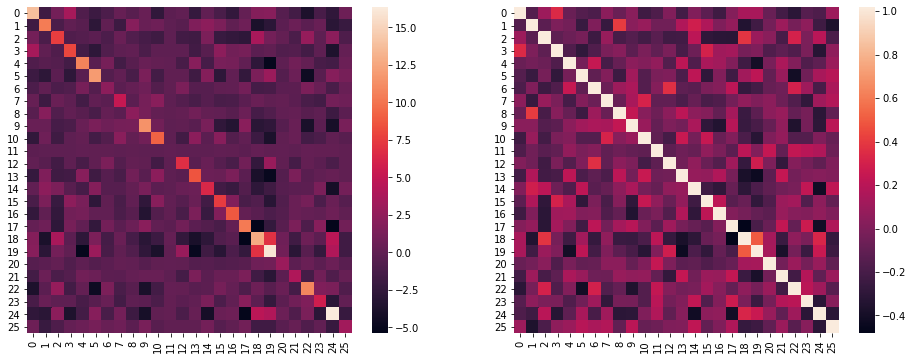

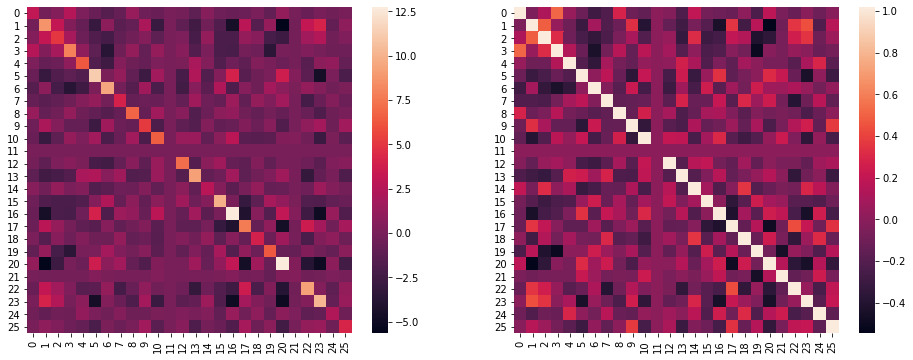

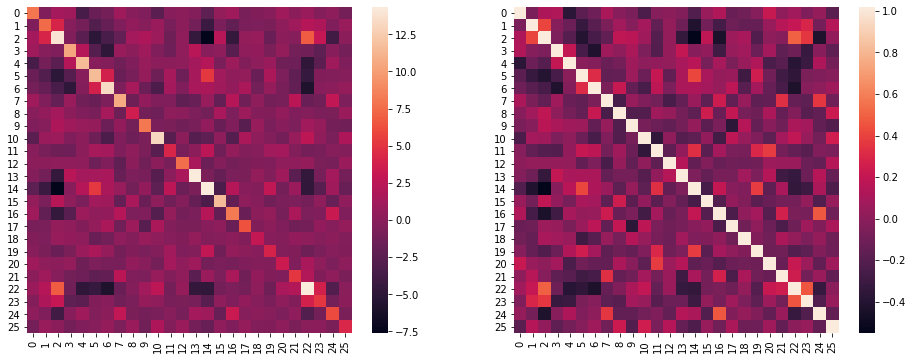

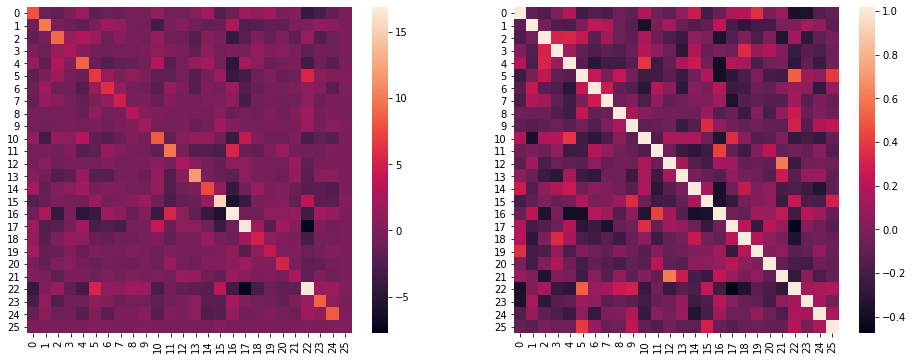

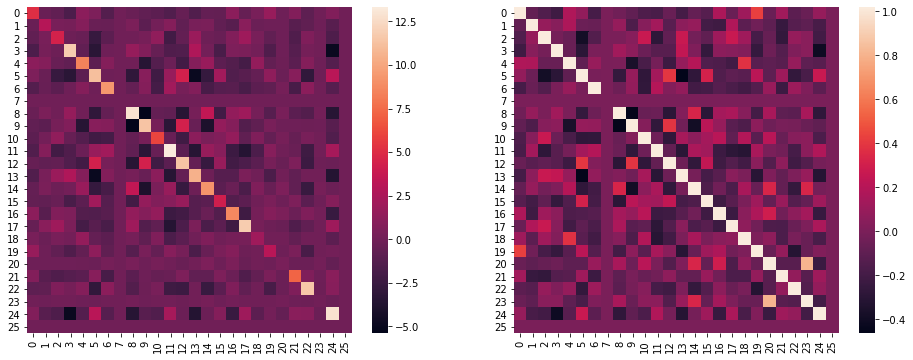

In [32]:
# compare normalized and non-normalized covariance matrices
years = [2016, 2017, 2018, 2019, 2021]
for year in years:
    df_wide, np_matrix, country_labels, voter_country_labels = create_df_wide_by_year(data, year=year)
    np_matrix_normalized = normalize_data(np_matrix)
    covariance_matrix(np_matrix, np_matrix_normalized)

##### Comments:
When we compare the covariance matrixes between non-normalized and normalized data, we can see that the variances of each feature (on the diagonal) varies with non-normalized data, but is the same (takes a value of 1) when we normalize the data. This can potentially skew the choice of axes for the principal components, so we'll work with normalized data going forward

In [33]:
def pca(np_matrix_normalized, np_matrix_col_names, evr=0.7):
    """Compute the principal components for plotting. Specify the required
    explained variance ratio (between 0 and 1) to compute the number of
    principal components.
    """
    pca = decomposition.PCA(n_components=evr)
    pca.fit(np_matrix_normalized)
    pca_transformed_values = pca.transform(np_matrix_normalized)
    pca_transformed_values_3d = pca_transformed_values[:,0:3]
    num_pc = pca.components_.T.shape[1]
    col_names = list(['PC'+str(i+1) for i in range(0,num_pc)])
    loadings = pd.DataFrame(pca.components_.T,
        columns=col_names,
        index=np_matrix_col_names) # how the original variables are correlated to the new PCAs
#     print("Number of Principal Components: ", num_pc)
#     print("PCA Explained Variance: ", np.sum(pca.explained_variance_ratio_))
#     print("PCA Explained Variance Ratio: ", pca.explained_variance_ratio_)
#     print("PCA Explained Variance Ratio (Top 3 Components): ", np.sum(pca.explained_variance_ratio_[0:3]))
#     print("PCA Loadings: ")
#     print(loadings)
    return pca_transformed_values, pca_transformed_values_3d

##### Comments:
To achieve a 70% explained variance ratio, we need 9-10 principal components. With 3 PCs, only 32%-38% of the variance is captured, so a 3D projection may not be a good representation of the data

In [34]:
def tsne(np_matrix_normalized):
    """Compute tsne for plotting"""
    perplexity = (np_matrix_normalized.shape[0]) ** 0.5
    tsne_transformed_values = manifold.TSNE(
        n_components=3, 
        perplexity=perplexity, learning_rate=100, random_state=1).fit_transform(np_matrix)
#    print(tsne_transformed_values)
    return tsne_transformed_values

In [35]:
def k_means_clustering(np_matrix):
    """Compute clusters
    Note: flat elbow seems to suggest there's not much clustering activity
    """
    distortions = []
    K = range(2,26)
    # calculate kmeans and plot to determine number of cluster via elbow method
    for k in K:
        kmeanModel = cluster.KMeans(n_clusters=k, random_state=1)
        kmeanModel.fit(np_matrix)
        distortions.append(kmeanModel.inertia_)
    # plt.figure(figsize=(16,8))
    # plt.plot(K, distortions, 'bx-')
    # plt.xlabel('k')
    # plt.ylabel('Distortion')
    # plt.title('The Elbow Method showing the optimal k')
    # plt.show()
    kmeans = (cluster.KMeans(n_clusters=4, random_state=0)
        .fit(np_matrix))
    labels = kmeans.labels_
#    print(labels)
    return labels

In [36]:
def merge_pca_k_means_to_df(df, pca_values, tsne_values, k_means_labels):
    df['pca1'] = pca_values[:,0]
    df['pca2'] = pca_values[:,1]
    df['pca3'] = pca_values[:,2]
    df['tsne1'] = tsne_values[:,0]
    df['tsne2'] = tsne_values[:,1]
    df['tsne3'] = tsne_values[:,2]
    df['kmeans_cluster'] = k_means_labels
    df = df.reset_index()
    df = df[['voter_country','voter','From','pca1','pca2','pca3','tsne1','tsne2','tsne3','kmeans_cluster']]
    df['kmeans_cluster'] = df.kmeans_cluster.astype(str)
    return df


In [37]:
def plot_chart_2d(df,year):
    """Plot diagram"""
    #plot 2d chart
    fig, ax1 = plt.subplots(1,1)
    sns.scatterplot(x="pca1", y="pca2", hue="kmeans_cluster", style="voter", palette="Set2", s=100, data=df, ax=ax1)
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    for line in range(0,df.shape[0]):
        ax1.text(df.pca1[line]+0, df.pca2[line], df.From[line], horizontalalignment='left', size='large', color='black')
    ax1.set_title('PCA Projection for Eurovision Song Contest Voting in {}'.format(year))
    fig.set_size_inches(16,16)
    plt.show()
    
#     fig, ax2 = plt.subplots(1,1)
#     sns.scatterplot(x="tsne1", y="tsne2", hue="kmeans_cluster", style="voter", palette="Set2", s=100, data=df, ax=ax2)
#     for line in range(0,df.shape[0]):
#         ax2.text(df.tsne1[line]+0, df.tsne2[line], df.From[line], horizontalalignment='left', size='large', color='black')
#     ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#     ax2.set_title('TSNE Projection')    
#     fig.set_size_inches(16,16)
#     plt.show()

def plot_chart_3d(df, year):    
    fig = px.scatter_3d(df, x='pca1', y='pca2', z='pca3', 
        color='kmeans_cluster', symbol='voter', hover_name='From', 
        width=800, height=800, title="PCA Projection for Eurovision Song Contest Voting in {}".format(year))
    fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside",
                                          ticksuffix=" bills"))
    fig.show()

#     fig = px.scatter_3d(df, x='tsne1', y='tsne2', z='tsne3', color='kmeans_cluster', symbol='voter', hover_name='From')
#     fig.show()
    

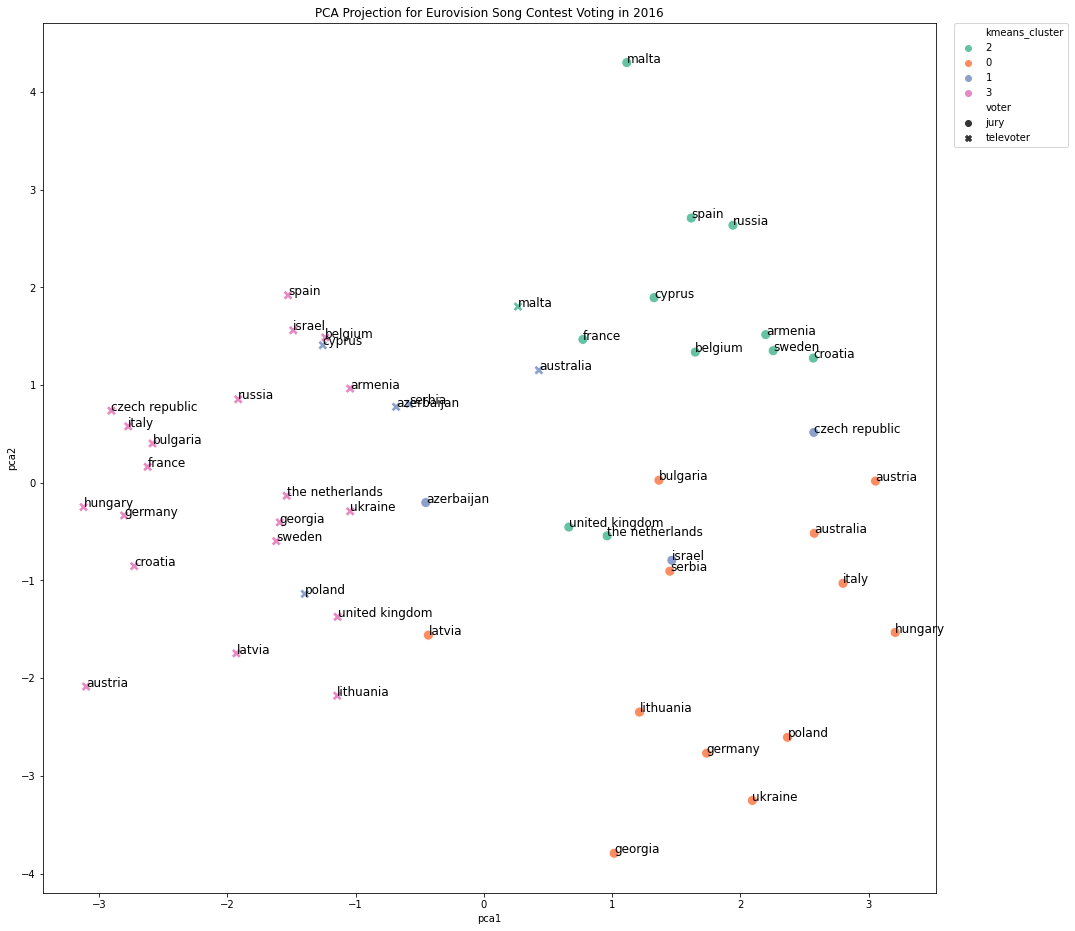

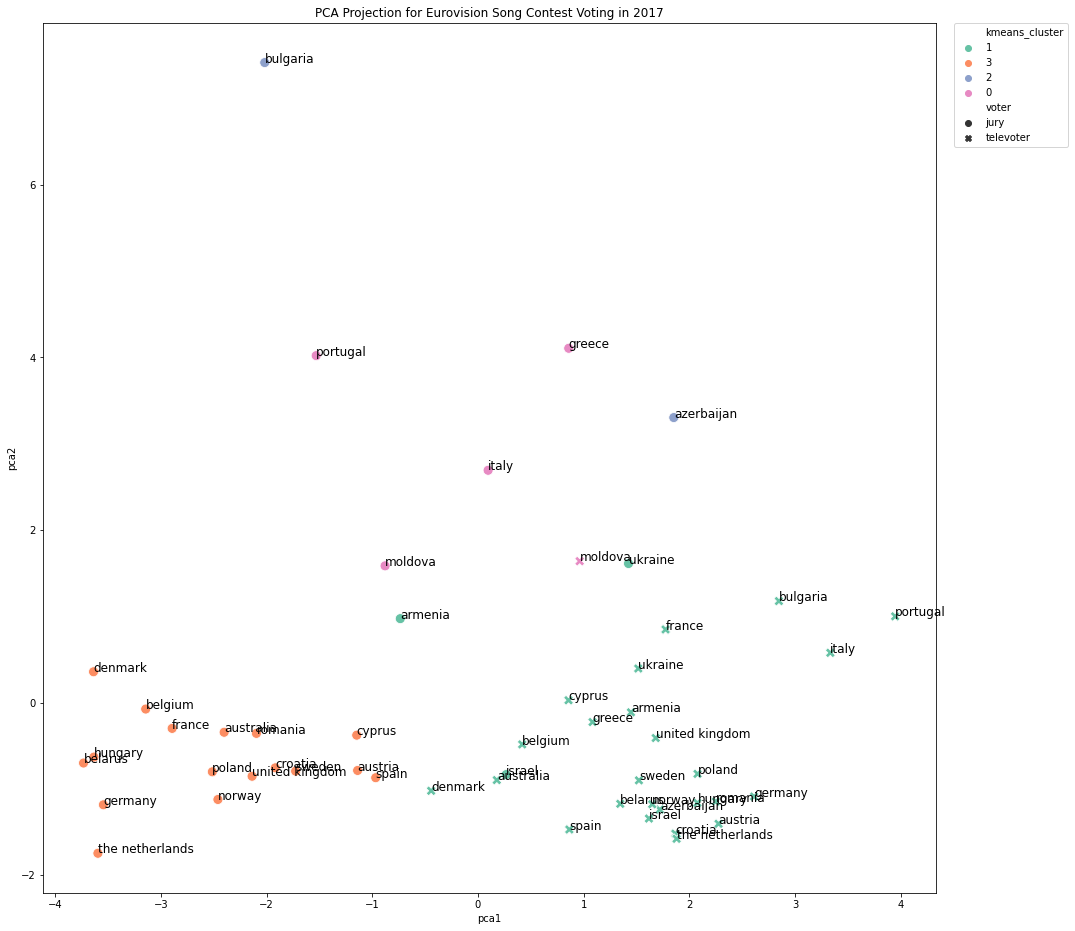

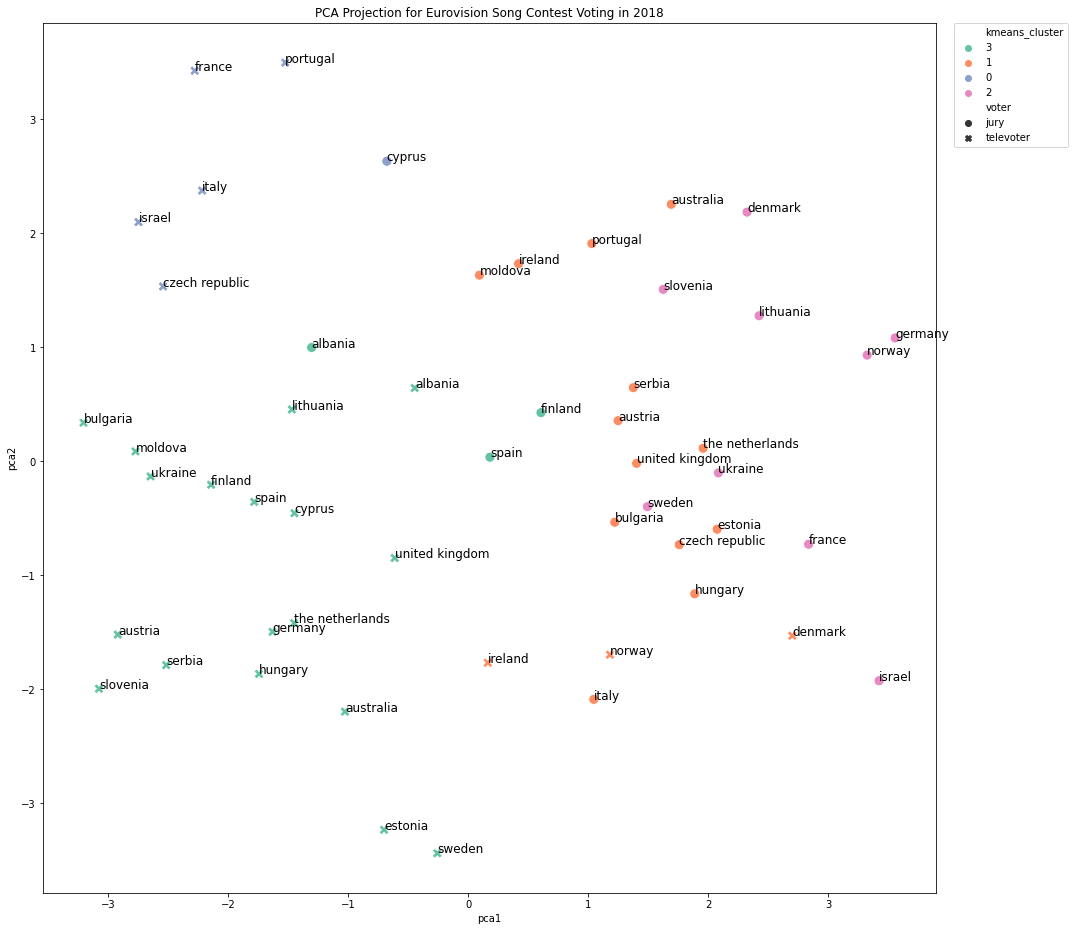

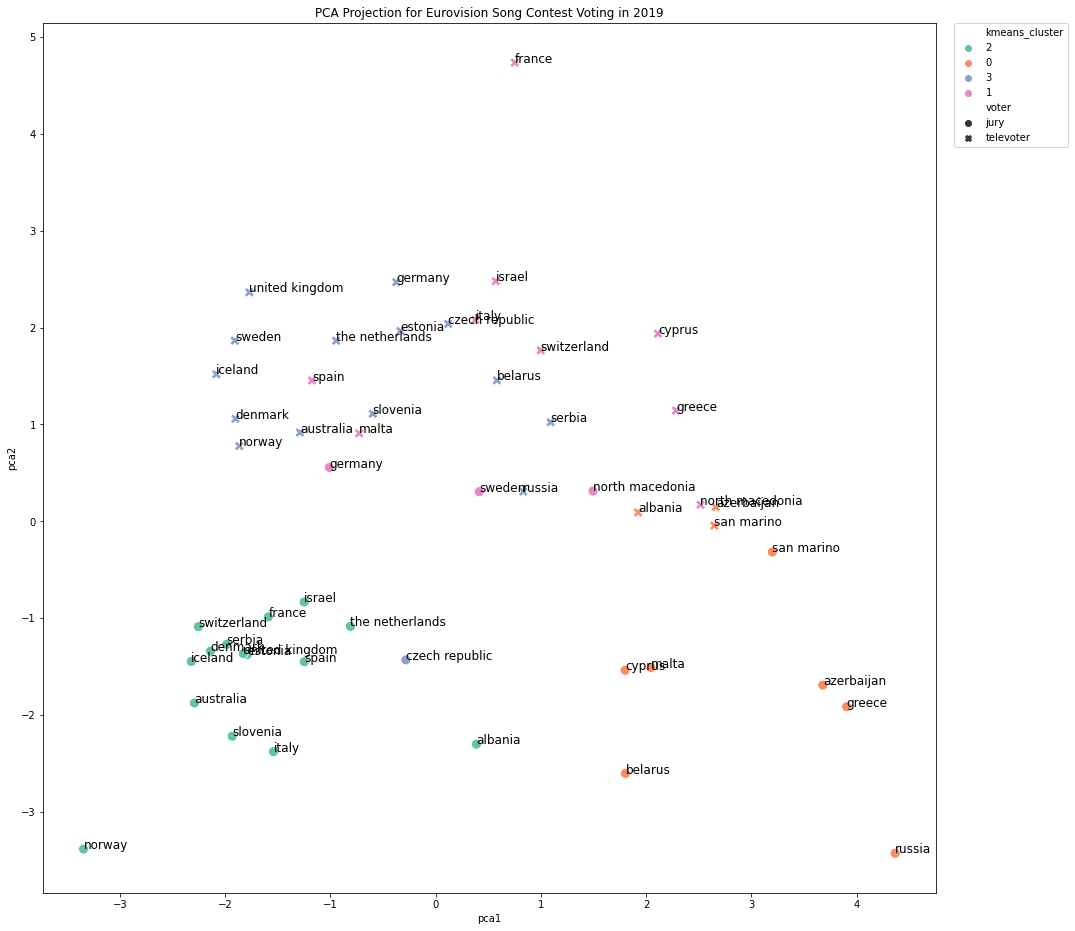

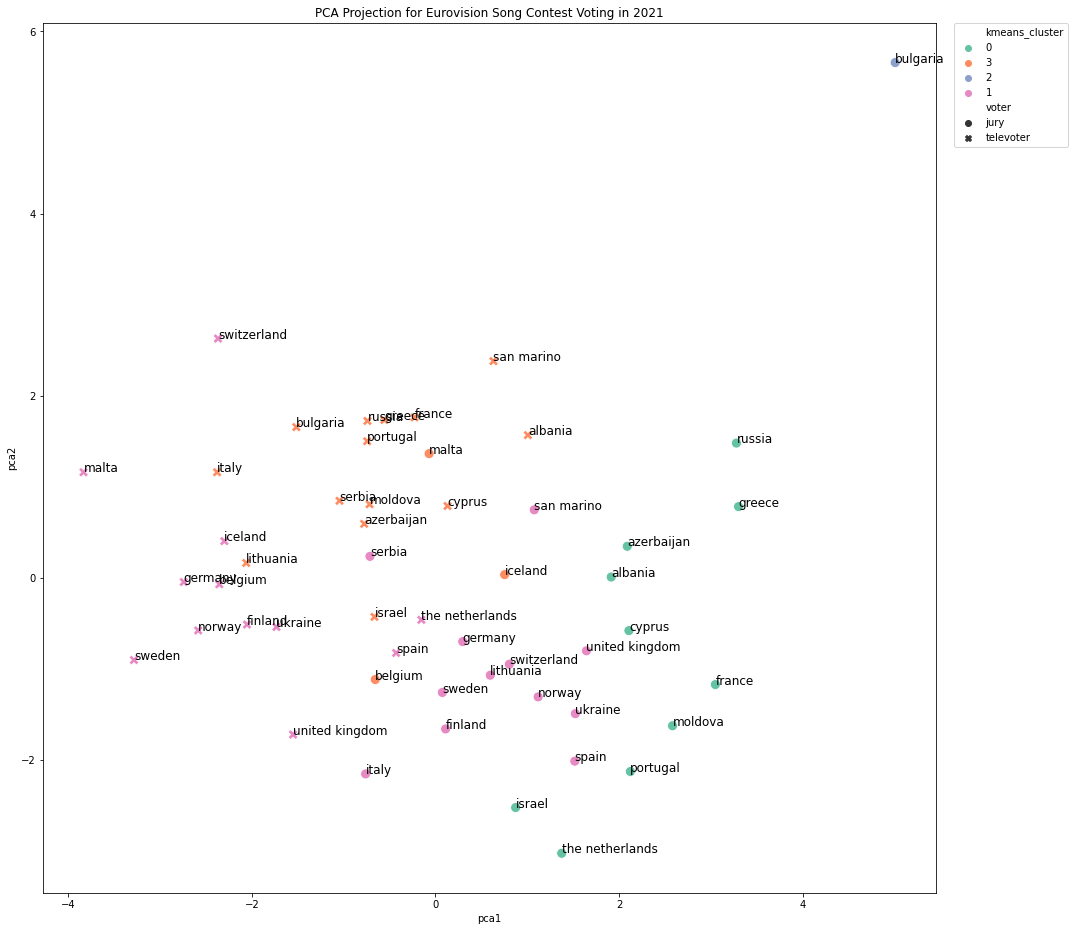

In [38]:
years = [2016, 2017, 2018, 2019, 2021]

for year in years:
    df_wide, np_matrix, country_labels, voter_country_labels = create_df_wide_by_year(data, year=year)
    np_matrix_normalized = normalize_data(np_matrix)
    pca_values, pca_values_3d = pca(np_matrix_normalized, country_labels)
    tsne_values = tsne(np_matrix_normalized)
    k_means_labels = k_means_clustering(np_matrix_normalized)
    df_plotting = merge_pca_k_means_to_df(df_wide, pca_values, tsne_values, k_means_labels)
    plot_chart_2d(df_plotting, year)
    plot_chart_3d(df_plotting, year)

##### Comments
The PCA projection reveals some patterns we saw earlier. (e.g. Bulgaria jury with a very different voting pattern to others in 2017). Bulgarian jury voting appears to be quite different in 2017 and 2021 (as shown by how far the point is away from the others). 

The TSNE projections require further tuning of the hyperparameters (perplexity and learning rate) to get a more useful projection.